2021.03.19 運禽車軌跡

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, shape
import folium
from folium import plugins
import datetime
%matplotlib inline

# 從運禽車軌跡找 **停留點**

## 讀入 單一車輛/司機 資料

In [3]:
path = r"G:\我的雲端硬碟\work\2021\1.農試所_大禽流感專案\1.資料\車軌資料、家禽健康證明書\漢名_運禽車資料\行駛軌跡(025-H9)-210607172929.xls"
df = pd.read_excel(path, parse_dates=True ,usecols = "A:I" , skiprows=3)

In [4]:
df.head()

,車 號,車 機,司 機,GPS時間,經 度,緯 度,位 置,車 速,狀 態
0,025-H9,359841083374516,江祈安,2021/06/02 00:00:08,121.432312,25.105695,248台灣新北市五股區凌雲路三段30號,1,停留
1,025-H9,359841083374516,江祈安,2021/06/02 00:00:39,121.432478,25.105625,248台灣新北市五股區凌雲路三段30號,2,停留
2,025-H9,359841083374516,江祈安,2021/06/02 00:01:09,121.432575,25.105483,248台灣新北市五股區凌雲路三段26號,4,停留
3,025-H9,359841083374516,江祈安,2021/06/02 00:01:39,121.432643,25.105433,248台灣新北市五股區凌雲路三段26號,2,停留
4,025-H9,359841083374516,江祈安,2021/06/02 00:02:09,121.432610,25.105467,248台灣新北市五股區凌雲路三段26號,1,停留


In [5]:
df.rename(columns={"經 度":"X",
                   "緯 度":"Y",
                   "GPS時間":"GPSDATETIME"
                  }, inplace=True)

In [6]:
wgs84 = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.X, df.Y), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

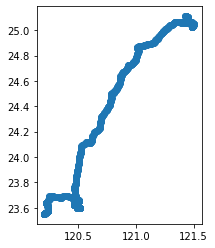

In [7]:
# 總行車軌跡
gdf.plot()

In [8]:
gdf.loc[:,"GPSDATETIME"] = pd.to_datetime(gdf.loc[:,"GPSDATETIME"])
gdf.loc[:,"date"] = gdf.loc[:,"GPSDATETIME"].dt.date

In [9]:
gdf.loc[:,"date"].unique()

array([datetime.date(2021, 6, 2), datetime.date(2021, 6, 3)], dtype=object)

## 挑出有移動行為的日期

In [10]:
# 以X座標的變化來判斷當天是否有出車
date_X_nuniq_df = gdf[["date", "X"]].groupby("date").X.nunique().reset_index()
date_X_nuniq_df

,date,X
0,2021-06-02,806
1,2021-06-03,1022


## 判斷為有值勤的日期: 當日不重複X座標大於100個

In [11]:
move_date_lst = date_X_nuniq_df.loc[date_X_nuniq_df.X>100, "date"]
move_date_lst

0    2021-06-02
1    2021-06-03
Name: date, dtype: object

## 挑選日期

In [12]:
# mask = gdf.loc[:,"date"].isin([datetime.date(2020, 10, 9)]) 

#觀察每一天
mask = gdf.loc[:,"date"].isin(move_date_lst)
gdf_pic = gdf[mask].reset_index(drop=True)

計算點位之間的時間差、距離差

In [13]:
# 原始 距離差 (可省略)
gdf_pic.loc[:,"position_lag1"] = gdf_pic.loc[:,"geometry"].shift(periods=1)
gdf_pic.to_crs('EPSG:5234')
gdf_pic.loc[:,"position_lag1_diff"] = gdf_pic["geometry"].distance(gdf_pic["position_lag1"])
gdf_pic.loc[:,"position_lag1_diff"].describe()

<ipython-input-13-eee45e2ec4f6>:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_pic.loc[:,"position_lag1_diff"] = gdf_pic["geometry"].distance(gdf_pic["position_lag1"])
<ipython-input-13-eee45e2ec4f6>:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: None

  gdf_pic.loc[:,"position_lag1_diff"] = gdf_pic["geometry"].distance(gdf_pic["position_lag1"])


count    2188.000000
mean        0.002535
std         0.004865
min         0.000000
25%         0.000055
50%         0.000185
75%         0.005485
max         0.104940
Name: position_lag1_diff, dtype: float64

In [14]:
# 原始 時間差
gdf_pic.loc[:,"time_lag1"] = gdf_pic.loc[:,"GPSDATETIME"].shift(periods=1)
gdf_pic.loc[:,"time_diff"] = (gdf_pic.loc[:,"GPSDATETIME"] - gdf_pic.loc[:,"time_lag1"])
gdf_pic.loc[:,"time_diff"].describe()

count                         2188
mean     0 days 00:01:18.957952468
std      0 days 00:01:41.509589086
min                0 days 00:00:07
25%                0 days 00:00:30
50%                0 days 00:00:30
75%                0 days 00:03:00
max                0 days 00:55:03
Name: time_diff, dtype: object

In [15]:
# 運禽車的移動(原始)
gdf_pic.loc[:,"position_lag1_diff"].describe()

count    2188.000000
mean        0.002535
std         0.004865
min         0.000000
25%         0.000055
50%         0.000185
75%         0.005485
max         0.104940
Name: position_lag1_diff, dtype: float64

## 挑選 運行狀態為非行駛(停留、怠速、熄火)

In [16]:
gdf_pic["狀 態"].unique()

array(['停留', '怠速', '行駛中', '超速', '熄火', '快速道路超速'], dtype=object)

In [42]:
# 運禽車的每個獨立點位的停留時間
mask_stay = gdf_pic["狀 態"].isin(['停留','怠速', '熄火'])
gdf_pic.loc[mask_stay,"geometry_str"] = gdf_pic.loc[mask_stay,"geometry"].astype(str)
point_time_sum_df = gdf_pic.loc[mask_stay, ["geometry_str","time_diff"]].fillna(pd.Timedelta(seconds=0)).groupby("geometry_str",as_index=False).sum()
point_time_sum_df.loc[:, "X"] = point_time_sum_df.loc[:,"geometry_str"].apply(lambda p:
                                                                             float(p.split(" ")[1].replace("(","")))
point_time_sum_df.loc[:, "Y"] = point_time_sum_df.loc[:,"geometry_str"].apply(lambda p:
                                                                             float(p.split(" ")[2].replace(")","")))
point_time_sum_df.rename(columns={"time_diff":"time_sum"}, inplace=True)
point_time_sum_df['time_sum'].describe()

count                         1220
mean     0 days 00:01:55.073770491
std      0 days 00:02:04.392183798
min                0 days 00:00:00
25%                0 days 00:00:30
50%                0 days 00:03:00
75%                0 days 00:03:00
max                0 days 00:55:03
Name: time_sum, dtype: object

In [43]:
# (option)計算每個點位最大/最小的時間
point_time_range_gp = gdf_pic.loc[mask_stay,["geometry_str","GPSDATETIME"]].groupby("geometry_str",as_index=False)
#min
point_time_min_df = point_time_range_gp.min()
point_time_min_df.rename(columns={"GPSDATETIME":"start_time"}, inplace=True)
#Max
point_time_max_df = point_time_range_gp.max()
point_time_max_df.rename(columns={"GPSDATETIME":"end_time"}, inplace=True)

# 合併
point_time_sum_maxmin_df = point_time_sum_df.merge(point_time_min_df, how="left", on="geometry_str")
point_time_sum_maxmin_df = point_time_sum_maxmin_df.merge(point_time_max_df, how="left", on="geometry_str")
point_time_sum_df = point_time_sum_maxmin_df.copy(deep=True)

In [44]:
# Timestamp -> formated str
point_time_sum_df.loc[:,"start_time"] = point_time_sum_df.loc[:,"start_time"].dt.strftime("%Y/%m/%d, %H:%M:%S")
point_time_sum_df.loc[:,"end_time"] = point_time_sum_df.loc[:,"end_time"].dt.strftime("%Y/%m/%d, %H:%M:%S")

In [45]:
point_time_sum_gdf = gpd.GeoDataFrame(
    point_time_sum_df, geometry=gpd.points_from_xy(point_time_sum_df.X, point_time_sum_df.Y), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## 停留點條件篩選: **停留5分鐘以上，2小時以下**

In [46]:
point_time_sum_gdf.time_sum.describe()

count                         1220
mean     0 days 00:01:55.073770491
std      0 days 00:02:04.392183798
min                0 days 00:00:00
25%                0 days 00:00:30
50%                0 days 00:03:00
75%                0 days 00:03:00
max                0 days 00:55:03
Name: time_sum, dtype: object

In [47]:
# 篩選條件 停留5分鐘以上，2小時以下
mask = (point_time_sum_gdf["time_sum"]>= datetime.timedelta(seconds=0, minutes=5, hours=0)) \
                & (point_time_sum_gdf["time_sum"]< datetime.timedelta(seconds=0, minutes=0, hours=2))

In [56]:
print(f">> 停留點數量: {len(point_time_sum_gdf[mask])}\n")

>> 停留點數量: 13



## 畫圖

In [49]:
locations = point_time_sum_gdf[mask][['Y', 'X']]
locationlist = locations.values.tolist()

In [50]:
time_sums = point_time_sum_gdf[mask]['time_sum'].apply(lambda t: str(t).split("days")[1].split(".")[0])
time_sumslist = time_sums.values.tolist()

In [51]:
# (option)時間動畫

features = [{
    'geometry': {
        'coordinates': list(row['geometry'].coords)[0],
        'type': 'Point'
    },
    'properties': {
        'icon': 'marker',
        'iconstyle': {
            'iconSize': [40, 40],
            'iconUrl':
            'https://www.flaticon.com/svg/vstatic/svg/664/664468.svg?token=exp=1616138018~hmac=c04c6983e10730773e5f5f124f7b42e5'
        },
        'id': 'house',
        'popup': 1,
        'times': [row["start_time"],row["end_time"]]
    },
    'type': 'Feature'
}
    for idx,row in point_time_sum_gdf.iterrows()
]

In [55]:
map = folium.Map(location=[23.762485, 120.827323], 
                 zoom_start=8, 
                 tiles='http://tile.stamen.com/toner/{z}/{x}/{y}.png', 
                 attr="https://stackoverflow.com/questions/48318538/folium-custom-map-tiles"
                )

# 運禽車完整路線
folium.Choropleth(
    LineString(gdf_pic['geometry'].to_list()),
    line_weight=3,
    line_color='#66B3FF',
    name="行車軌跡"
).add_to(map)

# 停留點聚合(如果太多)
marker_cluster = plugins.MarkerCluster().add_to(map)

# 目標的停留時間 點位
for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point],
                        radius=10,
                        color='#3186cc',
                        fill=True,
                        popup=time_sumslist[point],
                        fill_color='#3186cc'
                       ).add_to(marker_cluster)
#                        ).add_to(map)


    
# (option)加入時間
plugins.TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='PT2H' 
        , duration='PT1M'
        , add_last_point=False
        , auto_play=True
        , loop=False
        , max_speed=1
        , loop_button=True
        , date_options='YYYY/MM/DD HH:mm:ss'
        , time_slider_drag_update=True
    ).add_to(map)

# 加入底圖
folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/PHOTO2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="正射影像圖(通用版)",
#     overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
# folium.LayerControl().add_to(map)

folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/EMAP2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="臺灣通用電子地圖透明",
    show=False,
    overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
folium.LayerControl().add_to(map)

map

# 從運禽車軌跡找 **接觸禽場**

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString, shape
import folium
from folium import plugins
import datetime
%matplotlib inline

## 讀入 禽場資料

In [126]:
farm_path = r"G:\我的雲端硬碟\work\2021\1.農試所_大禽流感專案\1.資料\畜牧場資料\Farms.json"
farm_df = pd.read_json(farm_path)
print(farm_df.info())
farm_df[["FarmName","lat","lng"]].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16115 entries, 0 to 16114
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   FarmID             16115 non-null  int64 
 1   field2             16115 non-null  object
 2   Epi_Pre_Num        16115 non-null  object
 3   field4             16115 non-null  object
 4   countyname         16115 non-null  object
 5   townname           16115 non-null  object
 6   VillageName        16115 non-null  object
 7   Address            16115 non-null  object
 8   FarmName           16115 non-null  object
 9   Owner              16115 non-null  object
 10  OwnerTEL           16115 non-null  object
 11  FarmStatus         16115 non-null  object
 12  NativeChicken      16115 non-null  int64 
 13  BreederForNC       16115 non-null  int64 
 14  Broiler            16115 non-null  int64 
 15  BreederForBroiler  16115 non-null  int64 
 16  Layer              16115 non-null  int64

,FarmName,lat,lng
0,林照成,,
1,永成牧場,24.32885800,120.60480700
2,蔡農家畜禽飼養場,24.32967000,120.60452900
3,振昇畜牧場,24.37435800,120.66589100
4,元益牧場,24.42578100,120.63230700


## 移除座標有缺值的禽場

In [127]:
# string -> float
farm_df.loc[:,"lat"] = pd.to_numeric(farm_df.loc[:,"lat"], errors='coerce')
farm_df.loc[:,"lng"] = pd.to_numeric(farm_df.loc[:,"lng"], errors='coerce')

In [128]:
farm_df.loc[:,["lat","lng"]].isnull().sum()

lat    4496
lng    4496
dtype: int64

In [129]:
print(f">> 原資料數: {len(farm_df)}")
farm_df.dropna(subset=["lat","lng"], how="any", inplace=True)
print(f">> 後資料數: {len(farm_df)}")

>> 原資料數: 16115
>> 後資料數: 11619


## 建立禽場 gdf

In [191]:
wgs84 = 'epsg:4326'
farm_gdf = gpd.GeoDataFrame(
    farm_df, geometry=gpd.points_from_xy(farm_df.lng, farm_df.lat)
    , crs=wgs84
)

In [192]:
farm_gdf["geometry"].head()

1    POINT (120.60481 24.32886)
2    POINT (120.60453 24.32967)
3    POINT (120.66589 24.37436)
4    POINT (120.63231 24.42578)
5    POINT (120.61606 24.35903)
Name: geometry, dtype: geometry

## 讀入 單一車輛/司機 資料

In [44]:
driver_path = r"G:\我的雲端硬碟\work\2021\1.農試所_大禽流感專案\1.資料\車軌資料、家禽健康證明書\漢名_運禽車資料\行駛軌跡(025-H9)-210607172929.xls"
driver_df = pd.read_excel(driver_path, parse_dates=True ,usecols = "A:I" , skiprows=3)

In [46]:
driver_df.head()

,車 號,車 機,司 機,GPS時間,經 度,緯 度,位 置,車 速,狀 態
0,025-H9,359841083374516,江祈安,2021/06/02 00:00:08,121.432312,25.105695,248台灣新北市五股區凌雲路三段30號,1,停留
1,025-H9,359841083374516,江祈安,2021/06/02 00:00:39,121.432478,25.105625,248台灣新北市五股區凌雲路三段30號,2,停留
2,025-H9,359841083374516,江祈安,2021/06/02 00:01:09,121.432575,25.105483,248台灣新北市五股區凌雲路三段26號,4,停留
3,025-H9,359841083374516,江祈安,2021/06/02 00:01:39,121.432643,25.105433,248台灣新北市五股區凌雲路三段26號,2,停留
4,025-H9,359841083374516,江祈安,2021/06/02 00:02:09,121.432610,25.105467,248台灣新北市五股區凌雲路三段26號,1,停留


In [47]:
driver_df.rename(columns={"經 度":"X",
                   "緯 度":"Y",
                   "GPS時間":"GPSDATETIME"
                  }, inplace=True)

In [48]:
wgs84 = {'init': 'epsg:4326'}
driver_gdf = gpd.GeoDataFrame(
    driver_df, geometry=gpd.points_from_xy(driver_df.X, driver_df.Y), crs=wgs84)

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [193]:
# 總行車軌跡
driver_gdf['geometry']

0       POINT (121.43231 25.10570)
1       POINT (121.43248 25.10562)
2       POINT (121.43257 25.10548)
3       POINT (121.43264 25.10543)
4       POINT (121.43261 25.10547)
                   ...            
2184    POINT (121.43191 25.10578)
2185    POINT (121.43193 25.10580)
2186    POINT (121.43192 25.10576)
2187    POINT (121.43191 25.10578)
2188    POINT (121.43193 25.10578)
Name: geometry, Length: 2189, dtype: geometry

In [89]:
driver_gdf.loc[:,"GPSDATETIME"] = pd.to_datetime(driver_gdf.loc[:,"GPSDATETIME"])
driver_gdf.loc[:,"date"] = driver_gdf.loc[:,"GPSDATETIME"].dt.date

## 車軌 Buffer 100M

In [90]:
driver_geom = driver_gdf["geometry"].copy(deep=True)

### 車軌 需先轉換成 TWD97 121分帶 EPSG:3826 (單位: 公尺)

In [91]:
print(driver_geom.crs)
driver_geom_twd97 = driver_geom.to_crs("EPSG:3826")
print(driver_geom_twd97.crs)

+init=epsg:4326 +type=crs
EPSG:3826


### 將 車軌 從 點 轉換成 線

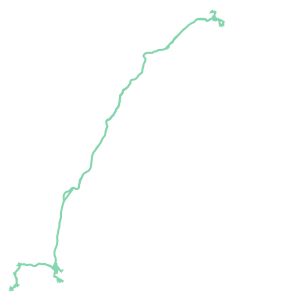

In [117]:
driver_geom_line = LineString(driver_geom_twd97.to_list())
driver_geom_line

In [120]:
driver_geom_line_buffer_100m = driver_geom_line.buffer(100)
# 需先將series 轉換回df 才能做交集
twd97 = {'init': 'epsg:3826'}

driver_geom_line_buffer_100m_df = gpd.GeoDataFrame(
    {'geometry': driver_geom_line_buffer_100m, 
     'temp':[True]}, 
     crs=twd97)

In [121]:
driver_geom_line_buffer_100m_df

,geometry,temp
0,"POLYGON ((168727.318 2605625.162, 168727.307 2...",True


### 禽場 需先轉換成 TWD97 121分帶 EPSG:3826 (單位: 公尺)

In [194]:
farm_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [212]:
farm_gdf_twd97 = farm_gdf.to_crs("EPSG:3826")
farm_gdf_twd97[["geometry","lat","lng"]].head()

,geometry,lat,lng
1,POINT (209895.055 2691500.973),24.328858,120.604807
2,POINT (209867.098 2691590.985),24.329670,120.604529
3,POINT (216106.144 2696524.004),24.374358,120.665891
4,POINT (212714.268 2702227.942),24.425781,120.632307
5,POINT (211045.967 2694838.996),24.359026,120.616057


### 車軌 Buffer 與禽場點位取交集

In [207]:
# 只允許 gdf之間做交集
intersection_farms = gpd.overlay(farm_gdf_twd97, driver_geom_line_buffer_100m_df ,  how='intersection')
print(f">> 交集禽場數: {len(intersection_farms)}\n")

>> 交集禽場數: 55



## 畫圖

In [210]:
# 經 緯
locationlist = [[point.xy[1][0], point.xy[0][0]] for point in intersection_farms.to_crs('EPSG:4326').geometry ]

In [211]:
map = folium.Map(location=[23.762485, 120.827323], 
                 zoom_start=8, 
                 tiles='http://tile.stamen.com/toner/{z}/{x}/{y}.png', 
                 attr="https://stackoverflow.com/questions/48318538/folium-custom-map-tiles"
                )

# 運禽車完整路線
folium.Choropleth(
    driver_geom_line_buffer_100m_df,
    line_weight=3,
    line_color='#66B3FF',
    name="行車軌跡"
).add_to(map)

# # 交集禽場聚合(如果太多)
marker_cluster = plugins.MarkerCluster().add_to(map)

# (交集) 禽場 點位
for point in range(0, len(locationlist)):
    folium.CircleMarker(locationlist[point],
                        radius=10,
                        color='#3186cc',
                        fill=True,
                        fill_color='#3186cc'
                       ).add_to(marker_cluster)



# 加入底圖
folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/PHOTO2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="正射影像圖(通用版)",
#     overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
# folium.LayerControl().add_to(map)

folium.raster_layers.TileLayer(
    tiles = "https://wmts.nlsc.gov.tw/wmts/EMAP2/default/GoogleMapsCompatible/{z}/{y}/{x}",                 
    attr = "國土測繪圖資服務雲",
    name="臺灣通用電子地圖透明",
    show=False,
    overlay=True,
    min_zoom=0,
    max_zoom=19,
    ).add_to(map)
folium.LayerControl().add_to(map)

map